In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from sklearn.model_selection import train_test_split

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.15.2'

In [3]:
# importing files
import zipfile
with zipfile.ZipFile('./trafficsigns_shapedata.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [3]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./trafficsigns_shapedata/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

In [4]:
data.label.unique()

array(['square', 'diamond', 'hex', 'triangle', 'round'], dtype=object)

In [5]:
data.shape

(3650, 2)

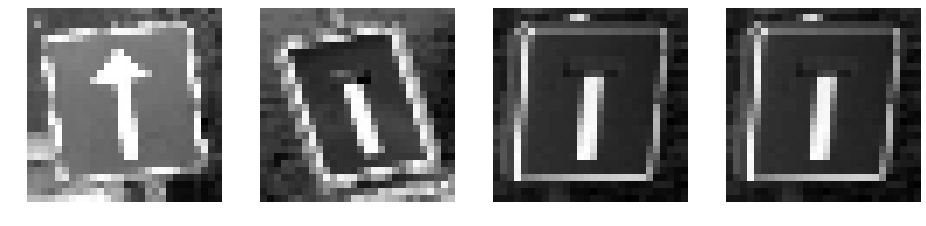

In [6]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [7]:
d = {'square':0, 'diamond':1, 'hex':2, 'triangle':3, 'round':4}
data['labels_num'] = data['label'].map(d, na_action='ignore')

In [8]:
data.columns

Index(['image_path', 'label', 'labels_num'], dtype='object')

In [9]:
trainData, validateData = train_test_split(data ,test_size=0.20, random_state=42)

In [10]:
trainData.shape

(2920, 3)

In [11]:
validateData.shape

(730, 3)

In [12]:
N_train_images = trainData.shape[0]
N_val_images = validateData.shape[0]

In [17]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [22]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

In [18]:
def train_model(model_, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2920 validated image filenames belonging to 5 classes.
Found 730 validated image filenames belonging to 5 classes.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
# model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_7 (Activation)    (None, 9, 9, 64)         

In [21]:
res = train_model(model_cnn, num_epoch=10, verbose=True)

Training epoch 0: Loss = 1.339540958404541, Accuracy = 0.4617486298084259
Validation epoch 0: Loss = 1.2764617774797522, Accuracy = 0.43885868787765503
Training epoch 1: Loss = 1.2280666828155518, Accuracy = 0.5131095051765442
Validation epoch 1: Loss = 0.8807354711967966, Accuracy = 0.760597825050354
Training epoch 2: Loss = 1.004656195640564, Accuracy = 0.6393967866897583
Validation epoch 2: Loss = 0.928349112039027, Accuracy = 0.654076099395752
Training epoch 3: Loss = 0.8800360560417175, Accuracy = 0.6838482022285461
Validation epoch 3: Loss = 0.4720030057689418, Accuracy = 0.851902186870575
Training epoch 4: Loss = 0.7477465271949768, Accuracy = 0.7420660257339478
Validation epoch 4: Loss = 0.40457589146883594, Accuracy = 0.8809782862663269
Training epoch 5: Loss = 0.697908341884613, Accuracy = 0.7684951424598694
Validation epoch 5: Loss = 0.3827074447079845, Accuracy = 0.8679347634315491
Training epoch 6: Loss = 0.6404089331626892, Accuracy = 0.7872005105018616
Validation epoch 6

NameError: name 'plot_results' is not defined

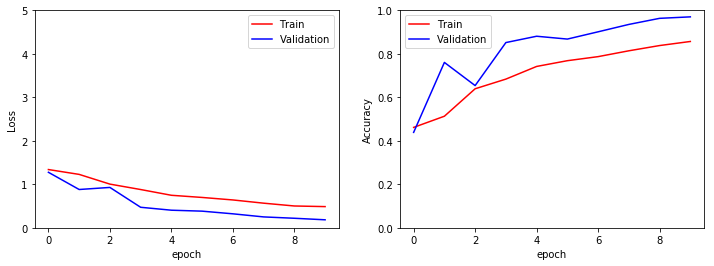

In [23]:
plot_results(res)